## Setup

We begin by loading the *poems* package and setting our output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems')
library(poems)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems'

# function to round to any arbitrary value
round_any <- function(x, accuracy, f = round) {
  f(x/ accuracy) * accuracy
}

### read data

In [2]:
#this is the land area of tasmania
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#1985-1995
# Cunningham et al., 2021
population_size=c(#34475,
 35924,
 38256,
 41029,
 43487,
 44622,
 46387,
 48845,
 50105,
 51618,
 52437,
 53067)

In [4]:
#this is the validation area of spotlight survey data from nva
valid_spotlight=read.csv('valid_spotlight.csv')

# Subset valid dataframe based on landarea
valid_spotlight=subset(valid_spotlight, index %in% landarea)

#reindex based on landarea
identity_spotlight=match(valid_spotlight$index,landarea)

In [5]:
#this is the validation area of camera trap
valid_camera=read.csv('valid_camera.csv')

# Subset valid dataframe based on landarea
valid_camera=subset(valid_camera, index %in% landarea)

#reindex based on landarea
identity_camera=match(valid_camera$index,landarea)

In [6]:
#this is the validation area of R drive
valid_monitor=read.csv('valid_monitor.csv')

# Subset valid dataframe based on landarea
valid_monitor=subset(valid_monitor, index %in% landarea)

#reindex based on landarea
identity_monitor=match(valid_monitor$index,landarea)

In [7]:
#habitat suitability map
#estimated via vegetation,altitude and seabird colony
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/habitat%20suitability%20tasman.ipynb
suitability=read.csv('suitability.csv')


floornum=0.1
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-floornum)+floornum

### known variables

In [8]:
#dispersal portion and avg distance
known_dispersal_p = 0.1945
known_dispersal_b =5.821

In [9]:
#baseline matrix is estimated via mark recapture data 
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/baseline%20matrix%2tasman.ipynb
leslie_matrix=c(0.        , 0.489, 1.4539, 1.947, 1.5079,0.547 ,
                1, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.976 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.899, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.84, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.791,
       0.791      )
agegroup=c("y0","y1","y2","y3","y4","y5")

In [10]:
#how many grid cells
gridlen=35

#coordinates extreme value
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895

In [11]:
#model start year
baseyear=1985

#years of simulation
simulation_years=40

#simulation timeframe per round
simulation_intervals=1

#number of simulations
num_of_sims=50

#max density 2 per sq km, in female model divided by two
maxden=100

#initial abundance
initial_population=34475

#validation threshold for camera and spotlight
correlation_threshold=0.9

#area name
areaname='Tasmania'

## Workflow

The *poems* workflow, which implements a pattern-oriented modeling (POM) approach 
(Grimm et al., 2005), is achieved via a framework of interoperable components:


The workflow is summarized by the following six steps:

1. Build the population model for the study region.
1. Build generators for dynamically generating model parameters.
1. Sample model and generator parameters for each simulation.
1. Build a simulation manager to run each simulation.
1. Build a results manager to generate summary results (metrics).
1. Build a validator to select a model ensemble.

### Step 1: Build the population model for the study region
Create a model template using the *PopulationModel* class. If the model is spatially
explicit, then define the study region via the *Region* class. All fixed model inputs,
such as environmental correlations, as well as any user-defined functions for processes
such as harvesting, should be set at this stage.

We could create these components in any order and set model parameters separately, but 
let's setup our study region, generate environmental correlations, and define a harvest
function prior to initializing the template model with all the fixed parameters.

##### Study region
First, we'll define our study region tasman with some longitude-latitude
coordinates.

In [12]:
(lonmax-lonmin)/gridlen
(latmax-latmin)/gridlen

In [13]:
#build the raster of channel
coordinates <- data.frame(x = rep(seq(lonmin, lonmax, 0.127028885714286), gridlen),
                          y = rep(seq(latmin, latmax, 0.1005383142857144),each= gridlen))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = areaname,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

##### Environmental correlation
Next, we'll define a distance-based spatial correlation for applying environmental 
stochasticity within our model. The generated correlation data is compacted for 
computational efficiency (with large-scale models).

In [14]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, amplitude = 0.4, breadth = 500)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

##### Template model
Finally, we can build our template model with these and other fixed parameters.

[0. , 0.489, 1.4539, 1.947, 1.5079,0.547]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.976, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.899, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.84, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.0, 0.791, 0.0]

In [15]:
# Build a stage matrix generator based on density dependant growth
stage_matrix_gen <- Generator$new(
  description = "stage matrix",
  base_matrix = matrix(leslie_matrix, nrow = length(agegroup), ncol = length(agegroup), byrow = TRUE,
                       dimnames = list(agegroup,agegroup )),
  inputs = c("growth_rate_max","initial_n", "density_max"),
  outputs = c("stage_matrix"),
  generative_requirements = list(stage_matrix = "function"))
stage_matrix_gen$add_function_template(
  "stage_matrix",
  function_def = function (params) {
    return(params$base_matrix*(1-params$initial_n/(params$density_max*659)))
  },
  call_params = c("base_matrix", "growth_rate_max","initial_n", "density_max"))

In [16]:
stage_matrix = matrix(leslie_matrix, nrow = length(agegroup), ncol = length(agegroup), byrow = TRUE,
                       dimnames = list(agegroup,agegroup ))

### Step 2: Build generators for dynamically generating model parameters
Some model parameters are single values, whilst others are represented as arrays and
other multi-value data structures. Usually, we don't wish to sample each individual 
value within these multi-value parameters (in step 3), but to generate them dynamically
via one or more intermediate sampled parameters. Here we build generators for model 
initial abundance, carrying capacity, and dispersal.

##### Habitat suitability
Firstly, our initial abundance and carrying capacity generator utilizes an example
(mock) habitat suitability for our defined study region. 

In [17]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

##### Initial abundance and carrying capacity generator
The generator utilizes generic template functionality for user-defined custom
functions. It uses sampled input parameters (initial total abundance and maximum cell
density), along with habitat suitability, to generate the desired output model 
parameters (initial abundance and carrying capacity) via these user-defined functions. 
Generators can also be configured to read values from files or generate values via 
probabilistic distributions. 

In [18]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              inputs = c("initial_n", "density_max"),
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
#                                        stats::rmultinom(1, size = params$initial_n,
#                                                       prob = params$example_hs)[,1]
                                       
                                       round(params$initial_n/sum(params$example_hs)*params$example_hs)
                                   },
                                   call_params = c("initial_n", "example_hs"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$density_max*params$example_hs)
                                   },
                                   call_params = c("density_max", "example_hs"))

In [19]:
dispersal_friction <- DispersalFriction$new(
   region = region,
   conductance = example_hs
 )

In [20]:
# Distance-based dispersal generator
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasmania/dispersal%20estimate%20tasmania.ipynb
dispersal_gen <- DispersalGenerator$new(region = region,
                                        dispersal_max_distance = 400, # in km 
                                        distance_scale = 1000,
                                        dispersal_friction =  dispersal_friction,
                                        inputs = c("dispersal_p", "dispersal_b"),
                                        decimals = 5)
dispersal_gen$calculate_distance_data() # pre-calculate
# test_dispersal <- dispersal_gen$generate(input_values = list(dispersal_p = known_dispersal_p, 
#                                                              dispersal_b = known_dispersal_b))
#head(test_dispersal$dispersal_data[[1]])

##### Density Dependence

In [21]:
# Define neighborhoods based on a 12 km home range from each 
# grid cell for density dependence calculations (using a dispersal generator)
distance_data <- dispersal_gen$distance_data[[1]]
nh_data <- distance_data[which(distance_data$distance_class <= 19), 2:1]

neighborhoods <- as.list(1:length(landarea))
for (i in 1:nrow(nh_data)) {
  neighborhoods[[nh_data$source_pop[i]]] <- c(neighborhoods[[nh_data$source_pop[i]]],
                                               nh_data$target_pop[i])
}
#neighborhoods[1:3] # examine

In [22]:
# User-defined function for Ricker logistic density dependence via neighborhoods
density_dependence <- list(
  neighborhoods = neighborhoods,
  function (params) {
    
    # Apply logistic density dependence using neighborhoods
    growth_rate_max <- params$growth_rate_max
    nh_density_abundance <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$density_abundance[nh_indices])
                                          }))
    nh_carrying_capacity <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$carrying_capacity[nh_indices])
                                          }))
    occupied_indices <- params$occupied_indices
    growth_rate <- (1 - (nh_density_abundance[occupied_indices]/
                                           nh_carrying_capacity[occupied_indices]))
    params$transition_array[, , occupied_indices] <-
      params$apply_multipliers(params$transition_array[, , occupied_indices],
                               params$calculate_multipliers(growth_rate))
    
    
    # Remove fecundities for single thylacines
    single_indices <- which(nh_density_abundance == 1)
    params$transition_array[, , single_indices] <-
      (params$transition_array[, , single_indices]*as.vector(+(!params$fecundity_mask)))
    
    return(params$transition_array)
  }
)

In [23]:
#stage_matrix # examine
model_template <- PopulationModel$new(region = region,
                                      time_steps = simulation_years, # years
                                      years_per_step = simulation_intervals,
                                      populations = region$region_cells, 
                                      stages = length(agegroup),
                                      stage_matrix = stage_matrix_gen$stage_matrix,
                                      #demographic_stochasticity = TRUE,
                                      #standard_deviation = 0.01,
                                      correlation = correlation,
                                      density_dependence = "logistic",
                                      results_selection = c("abundance"),
                                      simulation_order = c("results", "transition", "dispersal"))

### Step 3: Sample model and generator parameters for each simulation
In order to explore the model parameter space to find the best models, we generate
Latin hypercube samples of model and generator parameters to be simulated, using the
*LatinHypercubeSampler* class. This class has functionality for generating sample
parameters via Uniform, Normal, Lognormal, Beta, and Triangular distributions.

In [24]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()

#set as wide as possible
lhs_gen$set_uniform_parameter("growth_rate_max", lower = 0.01, upper = 0.99, decimals = 2)

#automatically fetched
lhs_gen$set_uniform_parameter("density_max", lower = as.integer(maxden*0.2), 
                              upper = as.integer(maxden*1.8), decimals = 2)
lhs_gen$set_uniform_parameter("initial_n", lower = as.integer(min(maxden*0.2*length(landarea),initial_population/2*0.2)),
                              upper = as.integer(min(maxden*1.8*length(landarea),initial_population/2*1.8)),
                              decimals = 0)
lhs_gen$set_uniform_parameter("dispersal_b", lower = 1,
                              upper = 50, decimals = 2)
lhs_gen$set_uniform_parameter("dispersal_p", lower = 0.01, upper = 0.99, decimals = 2)
sample_data <- lhs_gen$generate_samples(number = num_of_sims)

#remove max capacity smaller than initial population
sample_data=sample_data[sample_data$density_max*length(landarea)>=sample_data$initial_n,]
num_of_sims=length(row.names(sample_data))

#save as pickle
save(sample_data, file="sample data.Rda")

### Step 4: Build a simulation manager to run each simulation
We now wish to run a simulation for each set (or row) of sampled parameters. The
*SimulationManager* class manages the generation of parameters (via the generators),
the running the model simulations, and writing simulation results to disk. It also
maintains a log of each simulation's success and any errors or warnings encountered.

In [25]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, stage_matrix_gen, dispersal_gen),
                                     parallel_cores = 6,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run(results_dir = tempdir())
run_output$summary
#dir(OUTPUT_DIR, "*.RData") # includes result files 
#dir(OUTPUT_DIR, "*.txt") # plus simulation log

In [26]:
#get time id and space id
valid_monitor$yearid=valid_monitor$year-baseyear
valid_monitor$reindex=identity_monitor

# Create a list to store the functions
summary_functions <- list()

# Programmatically define the functions and add them to the list
for (i in 1:length(rownames(valid_monitor))) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("p", i)]] <- function(results,sid,tid,idx) {
    results$abundance[results$sid[results$idx],results$tid[results$idx]]
  }
}

#add correlation of non parametric ranking
for (i in 1:simulation_years) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("rho_spotlight", i)]] <- function(results,identity_spotlight,rank_act_spotlight,
                                                             sim_yrs) {
    rank_est <- rank(results$abundance[identity_spotlight,sim_yrs])
    cor(rank_est,rank_act_spotlight)
  }
}

for (i in 1:simulation_years) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("rho_camera", i)]] <- function(results,identity_camera,rank_act_camera,
                                                             sim_yrs) {
    rank_est <- rank(results$abundance[identity_camera,sim_yrs])
    cor(rank_est,rank_act_camera)
  }
}


for (i in 1:length(population_size)) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("total", i)]] <- function(results,pop_size) {
    results$all$abundance[pop_size]
  }
}

# Add the additional required function to the list
summary_functions[["n"]] <- "abundance"

In [27]:
# Create the ResultsManager object with summary_functions assigned
results_manager <-ResultsManager$new(
  simulation_manager = sim_manager,
  simulation_results = PopulationResults$new(),
  summary_metrics = paste0("p", 1:length(rownames(valid_monitor))),
  summary_matrices = c("n"),
  tid=valid_monitor$yearid,
  sid=valid_monitor$reindex,
  idx=1:length(rownames(valid_monitor)),
  sim_yrs=1:simulation_years,
  pop_size=1:length(population_size),
  rank_act_spotlight=order(order(valid_spotlight$dftd)),
  rank_act_camera=order(order(valid_camera$rel_abun)),
  summary_functions=summary_functions,  # Assign summary_functions here
  parallel_cores = 6
)

gen_output <- results_manager$generate()
gen_output$summary
#dir(OUTPUT_DIR, "*.txt") # plus generation log
# results_manager$summary_metric_data
# results_manager$summary_matrix_list

In [28]:
#monitor sites
tid=valid_monitor$yearid
sid=valid_monitor$reindex
raw_mat=results_manager$summary_matrix_list$n

#find validation target in abundance matrix
valid_target <- matrix(ncol = length(rownames(valid_monitor)), nrow = num_of_sims)  
for (i in 1:length(rownames(valid_monitor))) {
  valid_target[,i] <- raw_mat[,(tid[i]-1)*length(landarea)+sid[i]]}
results_manager$summary_metric_data[paste0("p", 1:length(rownames(valid_monitor)))]=valid_target

In [29]:
#calculate correlation for camera validation target
rank_act_camera=order(order(valid_camera$rel_abun))
    
rho_camera <- numeric(0)
for (i in 1:num_of_sims){
    first_row <- raw_mat[i, ]
    reshaped=matrix(first_row,nrow = simulation_years,
                    ncol = length(landarea))
    reshaped[is.na(reshaped)] <- 0 
    for (j in 1:simulation_years) {
    rank_est=rank(reshaped[j,identity_camera])    
    rho_camera <- c(rho_camera, cor(rank_act_camera,rank_est))
        }
}

results_manager$summary_metric_data[paste0("rho_camera", 1:simulation_years)]=t(matrix(rho_camera,nrow = simulation_years,
                    ncol = num_of_sims))

In [30]:
#calculate correlation for spotlight validation target
rank_act_spotlight=order(order(valid_spotlight$dftd))
    
rho_spotlight <- numeric(0)
for (i in 1:num_of_sims){
    first_row <- raw_mat[i, ]
    reshaped=matrix(first_row,nrow = simulation_years,
                    ncol = length(landarea))
    reshaped[is.na(reshaped)] <- 0 
    for (j in 1:simulation_years) {
    rank_est=rank(reshaped[j,identity_spotlight])    
    rho_spotlight <- c(rho_spotlight, cor(rank_act_spotlight,rank_est))
        }
}

results_manager$summary_metric_data[paste0("rho_spotlight", 1:simulation_years)]=t(matrix(rho_spotlight,nrow = simulation_years,
                    ncol = num_of_sims))

In [31]:
#calculate total abundance
pop_est=numeric(0)
for (i in 1:num_of_sims)
{
for (j in 1:length(population_size)){
    first_row <- raw_mat[i, ]
    reshaped=matrix(first_row,nrow = simulation_years,
                    ncol = length(landarea))
    reshaped[is.na(reshaped)] <- 0 
    pop_est <- c(pop_est, sum(reshaped[j,]))
}
    }
results_manager$summary_metric_data[paste0("total", 1:length(population_size))]=t(matrix(pop_est,nrow = length(population_size),
                    ncol = num_of_sims))

In [32]:
#save as pickle
save(results_manager, file="models.Rda")

### Step 6: Build a validator to select a model ensemble
We now select and analyze our 'best' models via a *Validator* class object, which by
default utilizes an approximate Bayesian computation (ABC) approach (Beaumont, Zhang, 
& Balding, 2002) provided by the *abc* library (Csillery et al., 2015). The validator
can be configured appropriately for a problem domain (see the *abc* documentation). 
Here we use the default configuration to select the best 3 models, along with a weight
value, which is indicative of the congruence between each model's summary metrics and 
the corresponding target patterns. Also provided (with the default settings) is a 
diagnostic output (PDF) file, containing statistical information for analyzing the 
contribution of model parameters in the selection/validation process (see the *abc* 
documentation). For our simple demonstration the metrics and corresponding targets are 
relatively trivial, having the aim of producing stable population abundances with high 
harvest. However, the package facilitates the use more complex spatio-temporal metrics 
and targets (demonstrated in more advanced vignettes).

In [12]:
#load pickle files so no need to retrain
load("models.Rda")
load("sample data.Rda")


raw_mat=results_manager$summary_matrix_list$n

In [13]:
#showna
validation_var=results_manager$summary_metric_data
length(row.names(validation_var[!complete.cases(validation_var),]))/length(row.names(validation_var))

[1] 0

In [14]:

validation_var=validation_var[complete.cases(validation_var),]
sample_data=sample_data[validation_var$index,]
selected_mat=raw_mat[validation_var$index,]
selected_mat[is.na(selected_mat)] <- 0 
row.names(sample_data) <- NULL
row.names(validation_var) <- NULL
validation_var$index=1:length(row.names(validation_var))

In [15]:
# #fill na with zero for those who got non na correlation
# na_index <- which(!is.na(validation_var$rho_spotlight))
# subset <- validation_var[na_index, ]
# subset[is.na(subset)]=0
# validation_var=rbind(validation_var[is.na(validation_var$rho_spotlight),],subset)

# #list of na
# remove_index=which(!complete.cases(validation_var))

# # Create a validator for selecting the 'best' example models
# if (length(remove_index)!=0)    {
#  sample_data = sample_data[-remove_index,]
#  validation_var=validation_var[-remove_index,]
#  row.names(sample_data) <- NULL
#  row.names(validation_var) <- NULL
# }

In [16]:
#get population est
obs_targets=valid_monitor$population
names(obs_targets)=paste0("p", 1:length(rownames(valid_monitor)))

#female model
obs_targets=as.integer(obs_targets/2)

#add non parametric targets
for (i in 1:simulation_years){
    obs_targets<-c(obs_targets,correlation_threshold)
    obs_targets<-c(obs_targets,correlation_threshold)}

#female model
pop_act=as.integer(population_size[1:length(population_size)]/2)

#add total abundance
obs_targets<-c(obs_targets,pop_act)

#### custom

In [17]:
#get top 100 or top 10
if (nrow(validation_var) > 500) {
  tol = 100
} else {
  tol =10
}

#get top tol smallest sse
sse=colSums(apply(validation_var[-1], 1, function(x) ((x - obs_targets)/obs_targets)^2))
idx_selected=order(sse)[1:tol]

In [18]:
#initialize variables
init_beta=sample(1/tol,tol,replace=TRUE)
X=validation_var[-1]
X=X[idx_selected,]
Y=obs_targets


#small nonparam
coeffs=c(rep(1,nrow(valid_monitor)),rep(0.2,simulation_years),
                                       rep(0.2,simulation_years),rep(1,length(population_size)))
#sse defined
numerator=rowSums(apply(X, 1, function(x) ((x - Y)/Y)^2))
#std defined
numerator=abs(apply(X, 2, sd)/apply(X, 2, mean))
                        
#compute validation target weightings
denominator=sum(numerator)
coeffs=numerator/denominator

#rescale
init_beta=init_beta/sum(init_beta)
coeffs=coeffs/sum(coeffs)

In [19]:
#weighted euclidean
cost_func <- function(beta, X, Y) {
  
  # Calculate the weightings matrix
  weightings <- matrix(beta, nrow = length(beta), ncol = ncol(X))
  
  # Calculate squared errors
  squared_errors <- ((colSums(weightings * X) - Y) / Y) ^ 2
  
  # Compute the final cost
  cost <- sum(squared_errors * coeffs)
  
  return(cost)
}

# Perform optimization
result <- optim(par = init_beta, 
                 fn = cost_func, 
                 X = X, 
                 Y = Y,
                 method = "L-BFGS-B", 
                 lower = rep(0, ncol(X)))

In [20]:
weights=data.frame(index=idx_selected,weight=result$par)

In [21]:

# validator <- Validator$new(simulation_parameters = sample_data,
#                            simulation_summary_metrics =validation_var[-1],
#                            observed_metric_targets = obs_targets,
#                            output_dir = OUTPUT_DIR)

# validator$run(tolerance = 0.2, output_diagnostics = TRUE)
# #rescale weights as they dont sum up to one
# weights=validator$selected_simulations 

In [22]:

weights$weight=weights$weight/sum(weights$weight)

In [23]:
#get posterior weighted avg, min and max
selected_data=sample_data[weights$index,]

posterior_max=sapply(selected_data, function(x) max(x, na.rm = TRUE))
posterior_min=sapply(selected_data, function(x) min(x, na.rm = TRUE))
posterior_p80=sapply(selected_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))                    
posterior_p20=sapply(selected_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
posterior_mean=colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

#get prior avg, min and max
prior_max=sapply(results_manager$sample_data, function(x) max(x, na.rm = TRUE))
prior_min=sapply(results_manager$sample_data, function(x) min(x, na.rm = TRUE))
prior_p80=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))
prior_p20=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
prior_mean=sapply(results_manager$sample_data, function(x) mean(x, na.rm = TRUE))

#create dataframe into a designated format
prior <- data.frame(  
    prior = paste(prior_mean, 
                   "(", prior_p20, "-",prior_p80, ")") )

posterior <- data.frame( posterior = paste(posterior_mean, 
                   "(", posterior_p20, "-",posterior_p80, ")") )

#add index column
params_distrib=cbind(prior,posterior)
row.names(params_distrib)=names(prior_mean)

In [40]:
paste(length(rownames(selected_data)),"out of",nrow(validation_var))

[1] "100 out of 4735"

In [25]:
params_distrib

,prior,posterior
,<chr>,<chr>
growth_rate_max,0.500868004223865 ( 0.21 - 0.79 ),0.27 ( 0.238 - 0.804 )
density_max,103.985647307286 ( 58.802 - 149.696 ),20.56 ( 21.776 - 26.37 )
initial_n,16792.6156282999 ( 8674 - 24974.6 ),13473 ( 6097 - 13266.6 )
dispersal_b,25.517368532207 ( 10.84 - 40.16 ),1.07 ( 10.68 - 39.622 )
dispersal_p,0.499558606124604 ( 0.208000000000001 - 0.79 ),0.24 ( 0.232 - 0.744 )


In [26]:
# Example data frame with min, max, and median values
data_summary <- data.frame(category=factor(c('growth_rate_max','density_max','initial_n','dispersal_p','dispersal_b')),
  min = 2*(posterior_p20-prior_min)/(prior_max-prior_min)-1,
  median = 2*(posterior_mean-prior_min)/(prior_max-prior_min)-1,
  max = 2*(posterior_p80-prior_min)/(prior_max-prior_min)-1
)

row.names(data_summary)=NULL

#add prior
new_row <- data.frame(
  category = factor(c("prior")),
  min = -0.6,
  median = 0,
  max = 0.6
)
data_summary=rbind(new_row,data_summary)

Warning message:
"package 'ggplot2' was built under R version 4.4.1"


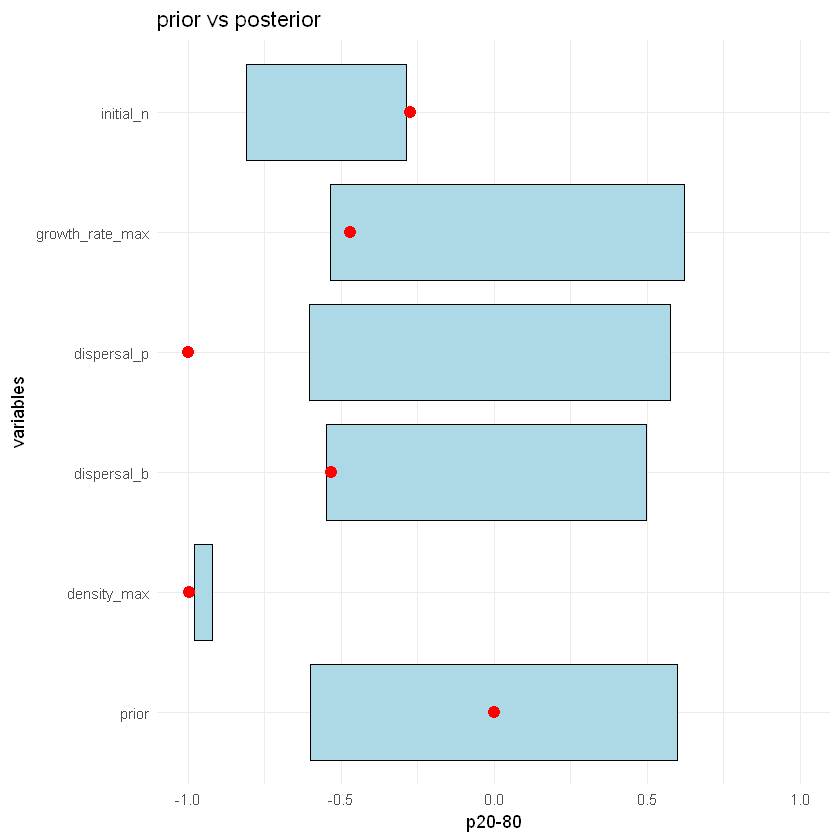

In [27]:
# Create the plot
library(ggplot2)
library(ggplot2)
p <- ggplot(data_summary, aes(y = category)) +
  geom_rect(aes(xmin = min, xmax = max, ymin = as.numeric(category) - 0.4, ymax = as.numeric(category) + 0.4), 
            fill = "lightblue", color = "black") +  # Draw the box
  geom_point(aes(x = median), color = "red", size = 3) +  # Mark the median
  labs(x = "p20-80", y = "variables", title = "prior vs posterior") +
  theme_minimal() +
  xlim(- 1, 1)  # Adjust these values as needed

# Print the plot
print(p)

In [28]:
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)

[1] "validation_diagnostics.pdf"

In [29]:
# install.packages('rmarkdown')

# library(rmarkdown)

# setwd("C:/Users/tm/Downloads/")

# input <- "poems tasman.ipynb"

# # First convert to .Rmd...
# convert_ipynb(input)

In [30]:
selected_mat=selected_mat[weights$index,]

In [31]:
write.csv(data.frame(selected_mat),'h:/raw.csv')

In [32]:
write.csv(data.frame(weights),'h:/weights.csv')

In [33]:
write.csv(data.frame(landarea),'h:/land.csv')

In [34]:
write.csv(data.frame(selected_data),'h:/rates.csv')

In [35]:
mean(colSums(apply(validation_var[-1], 1, function(x) ((x - obs_targets)/obs_targets)^2)))

[1] 2322.907

In [36]:
monitor_tar=validation_var[paste0("p", 1:length(rownames(valid_monitor)))]

est=colSums(monitor_tar[weights$index,]*weights$weight)
act=obs_targets[1:length(rownames(valid_monitor))]

est/act-1

p1          p2          p3          p4          p5          p6 
-0.71739130 -0.40000000 -0.13333333 -0.33333333 -0.43478261 -0.33333333 
         p7          p8          p9         p10         p11         p12 
 0.16666667 -0.15789474 -0.23529412  0.16666667  0.23076923  1.00000000 
        p13         p14         p15         p16         p17         p18 
 5.50000000  0.62500000  1.40000000 -0.18750000 -0.84810127  1.16666667 
        p19         p20         p21         p22         p23         p24 
 0.18181818 -0.74468085 -0.84705882 -0.42857143 -0.80000000 -0.25000000 
        p25         p26         p27         p28         p29         p30 
-0.80851064  2.00000000  0.09090909  0.71428571  0.71428571  0.71428571 
        p31         p32         p33         p34         p35         p36 
 0.09090909 -0.13333333 -0.12500000  1.66666667  0.16666667  0.00000000 
        p37         p38         p39         p40         p41         p42 
 1.28571429 -0.69047619 -0.79710145  0.14285714 -0.72549020 -0.72413793 
        p43 
-0.64444444

In [37]:
est

p1  p2  p3  p4  p5  p6  p7  p8  p9 p10 p11 p12 p13 p14 p15 p16 p17 p18 p19 p20 
 13  12  13  12  13  12   7  16  13  14  16  16  13  13  12  13  12  13  13  12 
p21 p22 p23 p24 p25 p26 p27 p28 p29 p30 p31 p32 p33 p34 p35 p36 p37 p38 p39 p40 
 13  12  13  12   9  12  12  12  12  12  12  13  14  16  14  16  16  13  14  16 
p41 p42 p43 
 14  16  16

In [38]:
sd(valid_monitor$population)
sd(est)

[1] 43.85266

[1] 1.893043